<a href="https://colab.research.google.com/github/apfoertn/Kaggle_Challenge/blob/master/Kopie_von_Kaggle_Houses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project description**

The goal of this competition and consequently of my notebook is to predict the sale price of residential homes in Ames, Iowa, by setting up different regression techniques. 

My notebook is therefore split up in the following parts:
1. Import all necessary packages
2. Import data
3. Getting in touch with the data
4. Have a look at the target variable 'SalePrice'
5. Other features, their correlation to the target variable 'SalePrice' and outliers
6. Fixing skewness of SalePrice
7. Search and handle NaN-values
8. Label Encoder
9. Fixing skewness of numerical features
10. Adding new features
11. Get dummies and split up data
12. Modelling
13. Submission




# 1. Import all necessary packages

In [1]:
#check if notebook runs in colab
import sys
IN_COLAB = 'google.colab' in sys.modules
print('running in Colab:',IN_COLAB)
path='..'
if IN_COLAB:
  #in colab, we need to clone the data from the repo
  !git clone https://github.com/apfoertn/Kaggle_Challenge.git
  path='Kaggle_Challenge'

running in Colab: True
fatal: destination path 'Kaggle_Challenge' already exists and is not an empty directory.


In [2]:
#import all necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.stats import skew 
from scipy.stats import boxcox_normmax
from scipy.special import boxcox1p
from sklearn.preprocessing import LabelEncoder 

#packages for modelling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import RandomizedSearchCV

#models
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from mlxtend.regressor import StackingCVRegressor

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 2. Import data

In [3]:
#import data from GitHub
train = pd.read_csv(path+'/data/train.csv')
test = pd.read_csv(path+'/data/test.csv')

# 3. Getting in touch with the data

Having a first look on the data to get a first impression of the datasets.

In [4]:
print('Number of observations in train data:',train.shape[0])
print('Number of colums in train data:', train.shape[1])

Number of observations in train data: 1460
Number of colums in train data: 81


In [5]:
#show the first 10 lines of train data
train.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,...,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,...,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,...,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,...,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,

In [6]:
print('Number of observations in test data:',test.shape[0])
print('Number of colums in test data:', test.shape[1])

Number of observations in test data: 1459
Number of colums in test data: 80


In [7]:
#show the first 10 lines of test data
test.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
5,1466,60,RL,75.0,10000,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1993,1994,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,763.0,763.0,GasA,Gd,Y,SBrkr,763,892,0,1655,0.0,0.0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1993.0,Fin,2.0,440.0,TA,TA,Y,157,84,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal
6,1467,20,RL,NaN,7980,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,1Story,6,7,1992,2007,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,Gd,PConc,Gd,TA,No,ALQ,935.0,Unf,0.0,233.0,1168.0,GasA,Ex,Y,SBrkr,1187,0,0,1187,1.0,0.0,2,0,3,1,TA,6,Typ,0,NaN,Attchd,1992.0,Fin,2.0,420.0,TA,TA,Y,483,21,0,0,0,0,NaN,GdPrv,Shed,500,3,2010,WD,Normal
7,1468,60,RL,63.0,8402,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1998,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,789.0,789.0,GasA,Gd,Y,SBrkr,789,676,0,1465,0.0,0.0,2,1,3,1,TA,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,393.0,TA,TA,Y,0,75,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal
8,1469,20,RL,85.0,10176,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,1Story,7,5,1990,1990,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,PConc,Gd,TA,Gd,GLQ,637.0,Unf,0.0,663.0,1300.0,GasA,Gd,Y,SBrkr,1341,0,0,1341,1.0,0.0,1,1,2,1,Gd,5,Typ,1,Po,Attchd,1990.0,Unf,2.0,506.0,TA,TA,Y,192,0,0,0,0,0,NaN,NaN,NaN,0,2,2010,WD,Normal
9,1470,20,RL,70.0,8400,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,4,5,1970,1970,Gable,CompShg,

If we compare both datasets, we see that the test data has one feature/column less than the train data. 

But if we think about our target variable 'SalePrice', which we wanna predict, it makes sense that it is missing in the test dataset.

Now let's see with which datatypes we are dealing with:

In [8]:
#check the occuring datatypes and their amount
train.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64

The result shows that we are dealing with numerical (int64 & float64) and categorical (object) data. Later on, we gonna check if they all are declared correct. For example, features containing a year/month are often declared as a numerical feature, but they should be handled as categorical. 

# 4. Have a look at the target variable 'SalePrice'

SalePrice is the target variable which we wanna predict. Therefore, we gonna have a closer look at it.

In [9]:
#get an overview over the feature SalePrice
train.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

The description of the SalePrice provides some interesting first insights:

*   The average price of a house is 180.921 dollars.
*   The cheapest house costs 349.000 dollars.
*   The most expensive house costs 755.000 dollars.

To get an impression of the distribution of the SalePrice let's plot it into a histogramm.





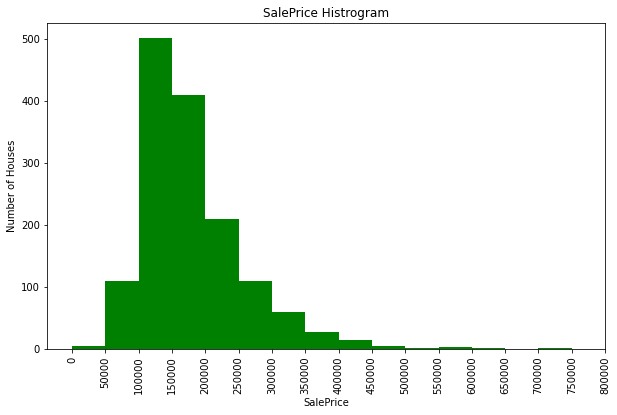

In [10]:
#group the sale price into categories to visualise distribution

#sort the values from the top to the least value
df = train.SalePrice.sort_values(ascending = False)
df

#create bins
binsVal = np.arange(0, 800000, 50000)
binsVal

#set figure size and create histogram
plt.figure(figsize=[10,6])
plt.hist(df, bins = binsVal, color='green')

#set the title, xticks and labels
plt.xlabel('SalePrice')
plt.xticks(rotation='90')
plt.xticks([0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000, 550000, 600000, 650000, 700000, 750000, 800000])
plt.ylabel('Number of Houses')
plt.title('SalePrice Histrogram')

#show plot
plt.show()

The first histogram created with matplotlib shows a first distribution of the SalePrice. 

You can see that almost 2/3(~900 of 1460) of the houses cost between 100.000 and 200.000 dollars and only a few houses cost more than 400.000 dollars.

Furthermore, it would be nice to have a best fit line, to be able to make a better statement about the distribution.

The best fit line could be created (in my opinion) in a very circumstantial way with matplotlib (tried it, but failed). But there is a better alternative: [seaborn.distplot](https://seaborn.pydata.org/generated/seaborn.distplot.html?highlight=distplot#seaborn.distplot)

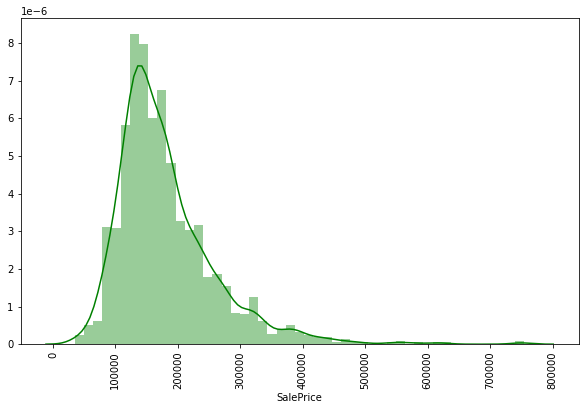

In [11]:
#set the size of the figure
plt.figure(figsize=[10,6])
plt.xticks(rotation='90')
#create plot
sns.distplot(train.SalePrice, color='green')
#show plot
plt.show()

As you can see the best fit line is already included in this kind of plot. 

The best fit line shows us that the SalePrice is not normally distributed, it is right-skewed! Right-skewed means that the tail is on the right side of the distribution and indicates a positive skewed data.([More info about skewness](https://medium.com/@TheDataGyan/day-8-data-transformation-skewness-normalization-and-much-more-4c144d370e55))

But let's check the skewness value:

In [12]:
train.SalePrice.skew()

1.8828757597682129

The skewness value of 1.8 confirms the assumption about the skewness. 

If the skewness value lies above 1 or is lower than -1 the distribution is highly skewed. ([More info about skewness](https://medium.com/@TheDataGyan/day-8-data-transformation-skewness-normalization-and-much-more-4c144d370e55))

Therefore, we need to transform the distribution of SalePrice.

But why? Because we need a normal distribution to get good predicitions with the ML models.

We gonna fix this, after we had a look on the other features and their correlation to the SalePrice.

# 5. Other features, their correlation to the target variable 'SalePrice' and Outliers

Let's have a look at the other features, their correlation with SalePrice and check outliers. 

We have already evaluated that we are dealing with numerical and categorical data. Let's see which features are of which datatype: 

In [13]:
#get all numerical columns 
numerical = train.dtypes[train.dtypes != 'object'].index

#get all categorical columns 
categorical = train.dtypes[train.dtypes == 'object'].index

#show both
print('List of numerical columns: \n',numerical, '\n\n')
print('List of categorical columns: \n',categorical)

List of numerical columns: 
 Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object') 


List of categorical columns: 
 Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'Bsm

The ID is included in the list of numerical features, but ID is only a random number for identification and doesn't have any impact on the SalePrice (our prediction). Therefore we gonna drop it.


In [14]:
#save IDs in a variable
train_id = train['Id']
test_id = test['Id']
#drop the feature 'ID'
train.drop(['Id'], axis = 1, inplace = True)
test.drop(['Id'], axis = 1, inplace = True)

Now let's check the correlation of all features with the target variable SalePrice.

In [15]:
#get correlation of all features with SalePrice and list them in descending order
corr = train.corr()
corr['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

As you can see, there are a lot of features correlated with the target feature SalePrice. Of course, SalePrice has the highest correlation with itself.

Let's have a closer look on the 10 most correlated features.

In [16]:
#get top10 most correlated features
corr10 = corr.nlargest(10, ['SalePrice'])

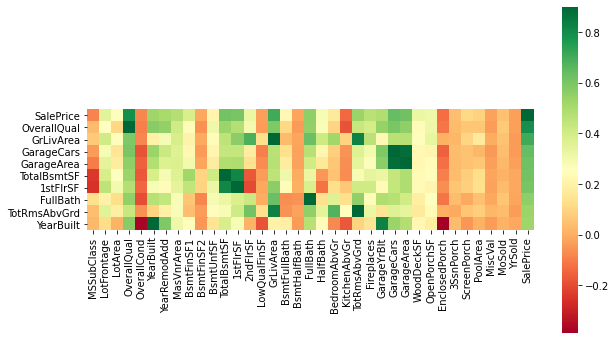

In [17]:
#plot heatmap of correlated features
plt.subplots(figsize=(10,6))
sns.heatmap(corr10, vmax=0.9, cmap='RdYlGn', square=True)
plt.show()

You can see the high correlation (green) of the features to SalePrice on the colum on the far right of the heatmap.

Let's visualise the top 9 most correlated features (SalePrice doesn't make sense):

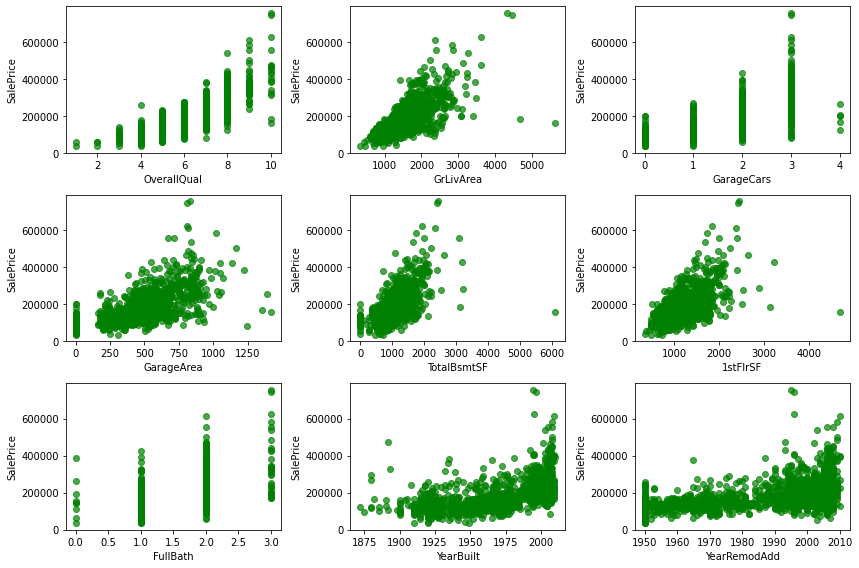

In [18]:
fig, axs = plt.subplots(3, 3, figsize=(12,8))
#OverallQual vs. SalePrice
axs[0, 0].scatter(train['OverallQual'], train['SalePrice'], c='green', alpha = 0.7)
axs[0, 0].set_xlabel('OverallQual')
axs[0, 0].set_ylabel('SalePrice')
#GrLivArea vs. SalePrice
axs[0, 1].scatter(train['GrLivArea'], train['SalePrice'], c='green', alpha = 0.7)
axs[0, 1].set_xlabel('GrLivArea')
axs[0, 1].set_ylabel('SalePrice')
#GarageCars vs. SalePrice
axs[0, 2].scatter(train['GarageCars'], train['SalePrice'], c='green', alpha = 0.7)
axs[0, 2].set_xlabel('GarageCars')
axs[0, 2].set_ylabel('SalePrice')
#GarageArea vs. SalePrice
axs[1, 0].scatter(train['GarageArea'], train['SalePrice'], c='green', alpha = 0.7)
axs[1, 0].set_xlabel('GarageArea')
axs[1, 0].set_ylabel('SalePrice')
#TotalBsmtSF vs. SalePrice
axs[1, 1].scatter(train['TotalBsmtSF'], train['SalePrice'], c='green', alpha = 0.7)
axs[1, 1].set_xlabel('TotalBsmtSF')
axs[1, 1].set_ylabel('SalePrice')
#1stFlrSF vs. SalePrice
axs[1, 2].scatter(train['1stFlrSF'], train['SalePrice'], c='green', alpha = 0.7)
axs[1, 2].set_xlabel('1stFlrSF')
axs[1, 2].set_ylabel('SalePrice')
#FullBath vs. SalePrice
axs[2, 0].scatter(train['FullBath'], train['SalePrice'], c='green', alpha = 0.7)
axs[2, 0].set_xlabel('FullBath')
axs[2, 0].set_ylabel('SalePrice')
#YearBuilt vs. SalePrice
axs[2, 1].scatter(train['YearBuilt'], train['SalePrice'], c='green', alpha = 0.7)
axs[2, 1].set_xlabel('YearBuilt')
axs[2, 1].set_ylabel('SalePrice')
#YearRemodAdd vs. SalePrice
axs[2, 2].scatter(train['YearRemodAdd'], train['SalePrice'], c='green', alpha = 0.7)
axs[2, 2].set_xlabel('YearRemodAdd')
axs[2, 2].set_ylabel('SalePrice')

fig.tight_layout()
plt.show()

As you can see in the graphs above, there are clearly some outliers in four relations: 
*   OverallQual vs. SalePrice
*   GrLivArea vs. SalePrice 
*   TotalBsmtSF vs. SalePrice
*   1stFlrSF vs. SalePrice

You can discuss if there are outliers in other relations too, but we don't want to delete too many data points.

So let's drop those outliers we have identified:



In [19]:
#drop outliers of SalePrice vs. OverallQual
train.drop(train[(train['OverallQual']<5) & (train['SalePrice']>200000)].index, inplace=True)
#drop outliers of SalePrice vs. GrLivArea
train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index, inplace=True)
#drop outliers of SalePrice vs. TotalBsmtSF
train.drop(train[(train['TotalBsmtSF']>5000) & (train['SalePrice']<300000)].index, inplace=True)
#drop outliers of SalePrice vs. 1stFlrSF
train.drop(train[(train['1stFlrSF']>5000) & (train['SalePrice']<300000)].index, inplace=True)
train.reset_index(drop=True, inplace=True)

# 6. Fixing skewness of SalePrice

To fix positively skewed data there are different common options. For example cube root transformation, square root transformation or logarithm transformation. [Fixing Skewness](https://medium.com/@TheDataGyan/day-8-data-transformation-skewness-normalization-and-much-more-4c144d370e55)

We are using the numpy function log1p. It applies log(1+x) to all elements of the column.

In [20]:
#transform SalePrice
train.SalePrice = np.log1p(train.SalePrice)

In [21]:
#check the skewness after transformation
train.SalePrice.skew()

0.12304515868289599

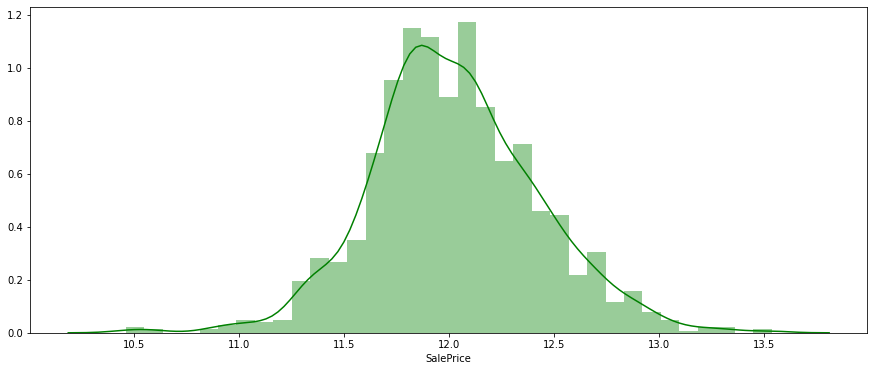

In [22]:
#plot the distribution after transformation
df2 = train.SalePrice.sort_values(ascending = False)

plt.figure(figsize=[15,6])
sns.distplot(df2, color='green')
plt.show()

You can see now, that the distribution is (almost) normally distributed. We can work on with this distribution.

# 7. Search and handle NaN-values

Another important aspect is searching and handling NaN-values (missing values). 

First we gonna concatenate both datasets so we can handle them both at once.

In [23]:
ntrain = train.shape[0]
ntest = test.shape[0]
#save the SalePrice values from the training set in a variable
y = train.SalePrice.values
#put train and test data together to handle both at once
concat_data = pd.concat((train, test)).reset_index(drop=True)
#drop target variable SalePrice because it's only part of train data
concat_data.drop(['SalePrice'], axis = 1, inplace = True)

In [24]:
#search NaN-values per column in combined data
missing_val_count_by_column = (concat_data.isnull().sum())

#show all columns which have NaN-values and the number of NaN-values in descending order 
nanvalues = missing_val_count_by_column[missing_val_count_by_column > 0].sort_values(ascending=False)
print('Number of NaN-values per column:\n',nanvalues)

Number of NaN-values per column:
 PoolQC          2907
MiscFeature     2811
Alley           2718
Fence           2345
FireplaceQu     1420
LotFrontage      485
GarageFinish     159
GarageYrBlt      159
GarageQual       159
GarageCond       159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Exterior2nd        1
Exterior1st        1
SaleType           1
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
Electrical         1
KitchenQual        1
GarageCars         1
GarageArea         1
TotalBsmtSF        1
dtype: int64


In [25]:
nanvalues_percent = ((missing_val_count_by_column[missing_val_count_by_column > 0]) / len(concat_data)*100).sort_values(ascending=False)
missing_percent = pd.DataFrame({'Missing Percentage':nanvalues_percent})
missing_percent

,Missing Percentage
PoolQC,99.691358
MiscFeature,96.399177
Alley,93.209877
Fence,80.418381
FireplaceQu,48.696845
LotFrontage,16.632373
GarageFinish,5.452675
GarageYrBlt,5.452675
GarageQual,5.452675
GarageCond,5.452675


In [26]:
nanvalues.count()

34

We got 34 different columns with NaN-values. Some of them have a really high percentage of missing values. We have to handle all of them before we gonna go on.

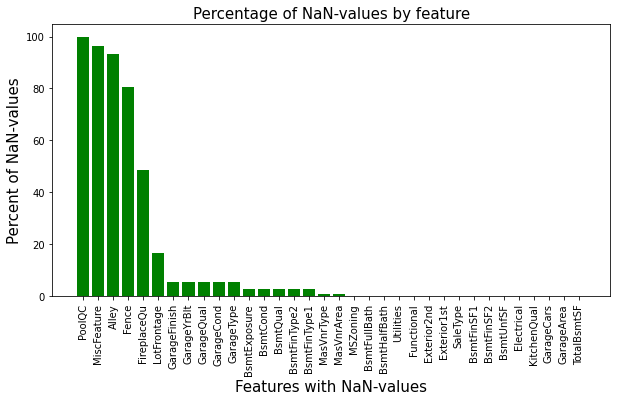

In [27]:
# Visualising percentage of NaN-values per feature
plt.figure(figsize=[10,5])
plt.bar(missing_percent.index, missing_percent['Missing Percentage'],color='green')
plt.xlabel('Features with NaN-values', fontsize=15)
plt.xticks(rotation='90')
plt.ylabel('Percent of NaN-values', fontsize=15)
plt.title('Percentage of NaN-values by feature', fontsize=15)
plt.show()

One way to handle the colums with a very high amount of missing data would be to drop them. But first let's have a look at the data description (data_description.txt) to see if it would make sense to drop them:

[More on handling NaN-values](https://www.kaggle.com/dansbecker/handling-missing-values)

If you go through all features you realise it doesn't make sense to delete those features. So we gonna go another way to handle the missing values: Imputation!



First we replace all the following features with 'None', because of the following explanations you get if you look them up in the description.txt:

*   PoolQC: NaN-value stands for 'No Pool'
*   MiscFeature: NaN-value stands for 'None'
*   Alley: NaN-value stands for 'No alley access'
*   Fence: NaN-value stands for 'No Fence'
*   FireplaceQu: NaN-value stands for 'No Fireplace'
*   GarageFinish: NaN-value stands for 'NoGarage'
*   GarageQual: NaN-value stands for 'No Garage'
*   GarageCond: NaN-value stands for 'No Garage'
*   GarageType: NaN-value stands for 'No Garage'
*   BsmtExposure: NaN-value stands for 'No Basement'
*   BsmtCond: NaN-value stands for 'No Basement'
*   BsmtQual: NaN-value stands for 'No Basement'
*   BsmtFinType2: NaN-value stands for 'No Basement'
*   BsmtFinType1: NaN-value stands for 'No Basement'
*   MasVnrType: NaN-value stands for 'None'

You could change them all one by one or all at once as seen in the following code:

In [28]:
#replacing NaN-values in colums where it means 'None' with 'None'
missing_none_col = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageType', 'BsmtExposure',
                   'BsmtCond', 'BsmtQual', 'BsmtFinType2', 'BsmtFinType1', 'MasVnrType'] 
for i in missing_none_col:
    concat_data[i] = concat_data[i].fillna('None')

Afterwards we replace all the following features with a '0':
*   GarageYrBlt: NaN-value stands for 'No Garage' and consequently there is no date available.
*   MasVnrArea: NaN-value stands for an area of 0 square feet.
*   BsmtFullBath: NaN-value stands for 0 full bathrooms in the basement.
*   BsmtHalfBath: NaN-value stands for 0 half bathrooms in the basement.
*   BsmtFinSF1: NaN-value stands for an area of 0 square feet.
*   BsmtFinSF2: NaN-value stands for an area of 0 square feet.
*   BsmtUnfSF: NaN-value stands for an area of 0 square feet.
*   GarageCars: NaN-value stands for zero cars (probably connected to having no garage at all --> no place for cars).
*   GarageArea: NaN-value stands for an area of 0 square feet (probably connected to having no garage at all).
*   TotalBsmtSF: NaN-value stands for an area of 0 square feet (probably connected to having no basement at all).

We gonna change them all at once again:

In [29]:
#replacing NaN-values with a 0
missing_zero_col = ['GarageYrBlt', 'MasVnrArea', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'GarageCars', 'GarageArea', 'TotalBsmtSF']

for i in missing_zero_col:
    concat_data[i] = concat_data[i].fillna(0)

If you browse the description it says for the feature 'Functional' to assume 'typical' unless deductions are warranted. Therefore we gonna replace the NaN-values with 'Typ':

In [30]:
#replacing NaN-values with 'Typ'
concat_data.Functional = concat_data.Functional.fillna('Typ')

The LotFrontage describes the 'Linear feet of street connected to property'. Assuming that it's almost the same to houses in the neighborhood, we fill the NaN-values with the median LotFrontage of the neighborhood:

In [31]:
#replacing NaN-values by the median value of the neighborhood
concat_data.LotFrontage = concat_data.groupby('Neighborhood').LotFrontage.transform(lambda x: x.fillna(x.median()))

There are some features including NaN-values left, which don't have a good explanation in the description. But they are all categorical features so it makes sense to replace the NaN-values with the value that appears most [(mode)](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.mode.html):

In [32]:
concat_data.Electrical.value_counts()

SBrkr    2668
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64

In [33]:
#replace NaN-values with the value that appears most (mode) 
concat_data.Electrical = concat_data.Electrical.fillna(concat_data.Electrical.mode()[0])
concat_data.KitchenQual = concat_data.KitchenQual.fillna(concat_data.KitchenQual.mode()[0])
concat_data.Exterior1st = concat_data.Exterior1st.fillna(concat_data.Exterior1st.mode()[0])
concat_data.Exterior2nd = concat_data.Exterior2nd.fillna(concat_data.Exterior2nd.mode()[0])
concat_data.Utilities = concat_data.Utilities.fillna(concat_data.Utilities.mode()[0])
concat_data.SaleType = concat_data.SaleType.fillna(concat_data.SaleType.mode()[0])
concat_data.MSZoning = concat_data.groupby('MSSubClass').MSZoning.transform(lambda x: x.fillna(x.mode()[0]))

If we check for example the feature 'Electrical' we can see that the one NaN-value got replaced by 'SBrkr', which is the most appearing value. So the code worked correctly.

In [34]:
concat_data.Electrical.value_counts()

SBrkr    2669
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64

Let's check if we handled all features including NaN-values:

In [35]:
#search NaN-values per column in combined data
missing_val_count_by_column = (concat_data.isnull().sum())

#show all columns which have NaN-values and the number of NaN-values in descending order 
nanvalues = missing_val_count_by_column[missing_val_count_by_column > 0].sort_values(ascending=False)
print('Number of NaN-values per column:\n',nanvalues)

Number of NaN-values per column:
 Series([], dtype: int64)


As you can see, we handled all missing values and there are no NaN-values left anymore.

After we fixed the missing values we need to change some features from numerical to categorical because they have been declared wrong:



In [36]:
#change datatype of the MSSubClass, YrSold and MoSold
concat_data.MSSubClass = concat_data.MSSubClass.apply(str)
concat_data.YrSold = concat_data.YrSold.astype(str)
concat_data.MoSold = concat_data.MoSold.astype(str)

# 8. Label Encoder

Some categorical features contain ordinal information. This means that the values can be ranked respectively be set in an relationship. You need to have a look on the description to find all of those features.

Therefore, we use the [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) to transform those features.

In [37]:
#show all categorical features
categoric = concat_data.dtypes[concat_data.dtypes == 'object'].index 
categoric

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition'],
      dtype='object')

In [38]:
#define all ordinal features
ordinal = ['MSSubClass', 'Street', 'Alley', 'LotShape', 'LandSlope', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
           'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',  'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 'FireplaceQu', 
           'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MoSold', 'YrSold']
        
#apply LabelEncoder to ordinal features
for c in ordinal:
    lbl = LabelEncoder() 
    lbl.fit(list(concat_data[c].values)) 
    concat_data[c] = lbl.transform(list(concat_data[c].values))

In [39]:
#show remaining categorical features
categoric = concat_data.dtypes[concat_data.dtypes == 'object'].index 
categoric

Index(['MSZoning', 'LandContour', 'Utilities', 'LotConfig', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
       'Heating', 'Electrical', 'GarageType', 'MiscFeature', 'SaleType',
       'SaleCondition'],
      dtype='object')

As you can see there are some categorical features left. We gonna handle them later on with 'get_dummies'.

# 9. Fixing skewness of numerical features

In this step we gonna check if some numerical features are skewed as well and, if so, we gonna fix them.

For SalePrice we used the numpy function log1p. Now we gonna use a box-cox transformation.

In [40]:
#show numerical features
numeric = concat_data.dtypes[concat_data.dtypes != 'object'].index 

In [41]:
#show the skewness value of numerical features and list them in descending order
skew_numeric = concat_data[numeric].apply(lambda x: skew(x)).sort_values(ascending=False)
skew_numeric

MiscVal          21.935910
PoolArea         17.685603
LotArea          13.262550
LowQualFinSF     12.082427
3SsnPorch        11.370087
LandSlope         4.994554
KitchenAbvGr      4.299698
BsmtFinSF2        4.143683
EnclosedPorch     4.001570
ScreenPorch       3.944305
BsmtHalfBath      3.929197
MasVnrArea        2.621183
OpenPorchSF       2.531807
WoodDeckSF        1.846168
1stFlrSF          1.258759
LotFrontage       1.103492
GrLivArea         1.068956
BsmtFinSF1        0.982003
BsmtUnfSF         0.919162
2ndFlrSF          0.861039
TotRmsAbvGrd      0.748849
Fireplaces        0.725620
HalfBath          0.696122
TotalBsmtSF       0.672442
BsmtFullBath      0.623366
OverallCond       0.569642
HeatingQC         0.484973
FireplaceQu       0.332022
BedroomAbvGr      0.326012
GarageArea        0.217093
OverallQual       0.189367
FullBath          0.164891
MSSubClass        0.139182
YrSold            0.132135
BsmtFinType1      0.082983
GarageCars       -0.218964
YearRemodAdd     -0.449662
B

A skewness value up to 0.5 is a reasonable value. So we filter and transform only the features which have a higher value.

In [42]:
#filter all skewed features with a higher skewness value than 0.5
high_skew = skew_numeric[skew_numeric > 0.5]
fix_skew = high_skew.index

In [43]:
#tranfsorm skewed data
for i in fix_skew:
    concat_data[i] = boxcox1p(concat_data[i], boxcox_normmax(concat_data[i] + 1))

# 10. Adding new features

Adding some new features to reduce complexity and dimensionality of data to make predictions easier. Because of time shortage I've only done some example features (time consuming to find matching relations between features), which show how to do it. There are more possible features which can be created in the future, to improve the predicitions furthermore. 

In [44]:
#create a variable which shows the total area of a house in square feet
concat_data['TotalSF'] = concat_data['TotalBsmtSF'] + concat_data['1stFlrSF'] + concat_data['2ndFlrSF'] + concat_data['GrLivArea'] + concat_data['GarageArea']

#create a variable which combines all types of porches
concat_data['PorchSF'] = concat_data['WoodDeckSF'] + concat_data['OpenPorchSF'] + concat_data['EnclosedPorch'] + concat_data['3SsnPorch'] + concat_data['ScreenPorch']

#create a variable which differs between having a pool and having no pool
concat_data['gotPool'] = concat_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)

# 11. Get dummies and split up data

Before we start modelling we need to change the rest of the categorical features to numerical ones, because the algorithms/models we gonna use work better with numerical features.

Therefore, I decided to go with [pandas.get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html), which converts categorical variables into dummy/indicator variables.

In [45]:
#get dummies
final_data = pd.get_dummies(concat_data)
#show shape
final_data.shape

(2916, 224)

In [46]:
#show first rows of final_data
final_data.head()

,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,...,Foundation_Stone,Foundation_Wood,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,10,18.133318,14.054263,1,1,3,0.0,7,3.466517,2003,2003,19.438231,2,4,2,4,3,2,143.920047,6,0.0,30.010267,422.114947,0,1,5.929136,1026.391549,0.0,8.339939,0.993263,0.000000,2,1.068921,3,0.750955,2,2.262646,6,0.000000,3,...,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,5,20.660028,14.347269,1,1,3,0.0,6,5.763540,1976,1976,0.000000,3,4,2,4,1,0,181.454701,6,0.0,44.168168,593.327333,0,1,6.224032,0.000000,0.0,7.962253,0.000000,0.710938,2,0.000000,3,0.750955,3,1.997107,6,0.903299,5,...,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,10,18.656316,14.716277,1,1,0,0.0,7,3.466517,2001,2002,17.773262,2,4,2,4,2,2,110.299851,6,0.0,56.942688,449.676734,0,1,5.984244,1041.273148,0.0,8.394288,0.993263,0.000000,2,1.068921,3,0.750955,2,1.997107,6,0.903299,5,...,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,11,17.239197,14.335210,1,1,0,0.0,7,3.466517,1915,1970,0.000000,3,4,4,1,3,0,61.728759,6,0.0,64.863764,378.526862,2,1,6.017495,905.115976,0.0,8.345041,0.993263,0.000000,1,0.000000,3,0.750955,2,2.137976,6,0.903299,2,...,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
4,10,21.300075,15.277957,1,1,0,0.0,8,3.466517,2000,2000,25.411668,2,4,2,4,0,2,136.439665,6,0.0,61.217218,544.803190,0,1,6.150533,1273.975831,0.0,8.654709,0.993263,0.000000,2,1.068921,4,0.750955,2,2.374499,6,0.903299,5,...,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


After we've handled all features, we can split up the data again into train and test data.

In [47]:
#split up the concatenated data again in train and test
train = final_data[:ntrain]
test = final_data[ntrain:]
#show the shape of both
print(train.shape)
print(test.shape)

(1457, 224)
(1459, 224)


In [48]:
#save train as variable X
X = train

In [49]:
#split the train data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#show the shape of the train and test sets
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(1019, 224) (1019,) (438, 224) (438,)


# 12. Modelling

Defining the scores which we take to check the performance of the different models.

In [50]:
#define calculation of train error
def rmse_train(model):
    return np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 10))

#define calculation of test error
def rmse_test(y_pred):
    return np.sqrt(mean_squared_error(y_test, y_pred))

## Setting up the chosen models

I decided to do 5 different regression techniques, which are all part of scikit learn, and to compare the results afterwards. 
The regression techniques are:
*   [RidgeCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html)
*  [LassoCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html)
*   [ElasticNetCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html)
*   [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) (suggested by Kaggle challenge overview)
*   [GradientBoostingRegression](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) (suggested by Kaggle challenge overview)

To find the best paramteres for the RandomForest and the GradientBoosting I included a RandomizedSearchCV. I've ran the notebook in Colab before and got the paramaters which I'm using in the set up of the models. Because of the time consumption (and the low compting power of my PC) I didn't run the RandomizedSearchCV again.

[Helpful information for RandomizedSearchCV](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74)

The parameter tuning can be expanded in the future to improve the models.

In [51]:
#Number of trees in random forest
#n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
#max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
#max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
#max_depth.append(None)
# Minimum number of samples required to split a node
#min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
#min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
#bootstrap = [True, False]
# Create the random grid
#random_grid = {'n_estimators': n_estimators,
#               'max_features': max_features,
#               'max_depth': max_depth,
#               'min_samples_split': min_samples_split,
#               'min_samples_leaf': min_samples_leaf,
#               'bootstrap': bootstrap}

In [52]:
#Use the random grid to search for best hyperparameters
#create the base model to tune
#rf = RandomForestRegressor()
#Random search of parameters, using 5 fold cross validation, 
#search across 100 different combinations, and use all available cores
#rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
#fit the random search model
#rf_random.fit(X_train,y_train)

In [53]:
#rf_random.best_params_ 

In [54]:
#the same procedure as before but now with the GradientBoostingRegressor
#gboost = GradientBoostingRegressor()

#parameters = {'learning_rate': [0.01,0.05],
#                  'n_estimators' : [2000,3000,5000],
#                  'max_depth'    : [2,4,6],
#                  'max_features': ['auto', 'sqrt'],
#                  'min_samples_leaf': [5, 10, 15],
#                  'min_samples_split': [5, 10]}
#gboost_random = RandomizedSearchCV(estimator=gboost, n_iter = 100, param_distributions = parameters, cv = 3, n_jobs=-1, random_state = 42)
#gboost_random.fit(X_train, y_train)

In [55]:
#gboost_random.best_params_ 

In [56]:
#set up all models 
#LassoCV
lasso_alphas = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
lasso = make_pipeline(RobustScaler(), LassoCV(alphas = lasso_alphas, max_iter = 10000, random_state = 1))

#RidgeCV
ridge_alphas = [1e-10,1e-8,1e-5,1e-4,1e-3,1e-2,0.5,1,1.5,2,3,4,5,10,20,30,40]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas))

#ElasticNetCV
elnet_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
elnet_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]
elnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=100000, alphas=elnet_alphas, l1_ratio=elnet_l1ratio, random_state = 1))

#GradientBoostingRegressor
gboost = GradientBoostingRegressor(n_estimators=5000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   random_state=42)

#RandomForestRegressor
rf = RandomForestRegressor(bootstrap = False, max_depth = 90, 
                           max_features = 'sqrt', min_samples_leaf = 1, 
                           min_samples_split = 5,n_estimators = 800, 
                           random_state = 42)

## Calculate the RMSE of all models

I calculated the Root Mean Square Error of all models to check the performance and to be able to compare all models.

The lower the RMSE score, the better the model.

In [57]:
#show  Root Mean Square Error (RMSE) of all models
score_lasso = rmse_train(lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(score_lasso.mean(), score_lasso.std()))

score_ridge = rmse_train(ridge)
print("Ridge score: {:.4f} ({:.4f})\n".format(score_ridge.mean(), score_ridge.std()))

score_elnet = rmse_train(elnet)
print("ElNet score: {:.4f} ({:.4f})\n".format(score_elnet.mean(), score_elnet.std()))

score_gboost = rmse_train(gboost)
print("GBoost score: {:.4f} ({:.4f})\n".format(score_gboost.mean(), score_gboost.std()))

score_rf = rmse_train(rf)
print("Random Forest score: {:.4f} ({:.4f})\n".format(score_rf.mean(), score_rf.std()))

Lasso score: 0.1099 (0.0112)

Ridge score: 0.1092 (0.0113)

ElNet score: 0.1101 (0.0114)

GBoost score: 0.1164 (0.0129)

Random Forest score: 0.1388 (0.0125)



In [58]:
#create a table of train error results
train_error = pd.DataFrame({
    'model': ['Lasso',
              'Ridge',
              'ElasticNet',
              'GBoost',
              'RandomForest'],
    'score': [score_lasso.mean(),
              score_ridge.mean(),
              score_elnet.mean(),
              score_gboost.mean(),
              score_rf.mean()]})

#build dataframe of values
train_error_df = train_error.sort_values(by='score', ascending=True).reset_index(drop=True)
train_error_df

,model,score
0,Ridge,0.109226
1,Lasso,0.109905
2,ElasticNet,0.110080
3,GBoost,0.116379
4,RandomForest,0.138751


## Fitting the models

In [59]:
#fitting all models
lasso_model = lasso.fit(X_train, y_train)
ridge_model = ridge.fit(X_train, y_train)
elnet_model = elnet.fit(X_train, y_train)
gboost_model = gboost.fit(X_train, y_train)
rf_model = rf.fit(X_train, y_train)

## Making predictions

In the following step I'm making the predictions with all models on X_test and the original test dataset. Furthermore, I save each predicted prices in a variable to work with it in the next step. 

You also need to apply the np.expm1 to transform the SalePrice back after the log1p transformation before to get the right values.

In [60]:
#predictions with all models
lasso_pred = lasso_model.predict(X_test)
finallasso = np.expm1(lasso_model.predict(test))

ridge_pred = ridge_model.predict(X_test)
finalridge = np.expm1(ridge_model.predict(test))

elnet_pred = elnet_model.predict(X_test)
finalelnet = np.expm1(elnet_model.predict(test))

gboost_pred = gboost_model.predict(X_test)
finalgboost = np.expm1(gboost_model.predict(test))

rf_pred = rf_model.predict(X_test)
finalrf = np.expm1(rf_model.predict(test))

## Calculating the average SalePrice out of all predicted values

My first idea was to simply take the predicted values from all models and divide them by the number of models. Consequently, the result is the average predicted SalePrice.

In [61]:
#calculate the average SalePrice out of all models
average_pred = (lasso_pred + ridge_pred + elnet_pred + gboost_pred + rf_pred) / 5
average = (finallasso + finalridge + finalelnet + finalgboost + finalrf) / 5

## Stacking

After combining the different models in an easy way by just taking the average SalePrice out of all five models, I decided to try Stacking as well. 

I used ridge as the meta_regressor because it has the best RMSE training score.

In [62]:
#set up stacking model
stack = StackingCVRegressor(regressors=(lasso, gboost, elnet, rf),
                                meta_regressor= ridge,
                                use_features_in_secondary=True)

In [63]:
#calculate and show training error
score_stack = np.sqrt(-cross_val_score(stack, np.array(X_train), np.array(y_train), scoring="neg_mean_squared_error", cv = 10))

print(score_stack.mean())

0.11379381746571267


In [64]:
#fit stacking model
stack_model = stack.fit(np.array(X_train), np.array(y_train))

In [65]:
#predict with stacking model
stack_pred = stack_model.predict(X_test)

In [66]:
#show predictions of house prices with the stacking model
finalstack = np.expm1(stack_model.predict(test))

In [67]:
#create a table of train error results
test_error = pd.DataFrame({
    'model': ['Lasso',
              'Ridge',
              'ElasticNet',
              'GBoost',
              'RandomForest',
              'Average',
              'Stack'],
    'score': [rmse_test(lasso_pred),
              rmse_test(ridge_pred),
              rmse_test(elnet_pred),
              rmse_test(gboost_pred),
              rmse_test(rf_pred),
              rmse_test(average_pred),
              rmse_test(stack_pred)]})

#build dataframe of values
test_error_df = test_error.sort_values(by='score', ascending=True).reset_index(drop=True)
test_error_df

,model,score
0,Stack,0.118424
1,Average,0.118922
2,ElasticNet,0.119127
3,Lasso,0.119198
4,Ridge,0.120332
5,GBoost,0.132068
6,RandomForest,0.134947


The test error score for the simple average model is the lowest. Therefore, we gonna use it for the final submission.

# 13. Submission

In [68]:
#submission taking the simple average predictions
sub = pd.DataFrame()
sub['Id'] = test_id
sub['SalePrice'] = average
sub.to_csv('submission.csv',index=False)
sub.head()

,Id,SalePrice
0,1461,121292.805968
1,1462,158148.767785
2,1463,185354.348017
3,1464,194800.356819
4,1465,195120.105323
